# **Genre Prediction From Summary - Goodreads**

This project aims to predict book genres using a dataset scraped from Goodreads.com, a well-known platform for book enthusiasts. The dataset includes essential features such as:

- Book URLs
- Summaries
- Genres
  
**Objective:**
Develop a DistilBERT-based model capable of accurately predicting book genres based on the provided summary.

**Key Steps in the Workflow:**

1. **Data Cleaning**

- Removing rows with missing values and duplicates to ensure data integrity.
- Writing a function to clean Summary text 

2. **Feature Engineering**

- Grouping related genres (e.g., merging Adventure and Mythology with Fantasy) to improve model performance and reduce complexity.
- Dropping unnecessary genres or those with a low count.
- Dropping summaries in languages other than English.
- Using a dataset from Kaggle and merging it with the original dataset to reduce imbalance.

## **1. Import Necessary Libraries**

In [1]:
pip list

Package                   Version
------------------------- ---------------
absl-py                   2.1.0
aiofiles                  23.2.1
altair                    5.4.1
annotated-types           0.7.0
anyio                     4.2.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.2.0
autocorrect               2.6.1
Babel                     2.14.0
beautifulsoup4            4.12.3
black                     21.12b0
blackcellmagic            0.0.3
bleach                    6.1.0
blinker                   1.8.2
cachetools                5.5.0
catboost                  1.2.5
certifi                   2024.2.2
cffi                      1.16.0
chardet                   3.0.4
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.1
contourpy       

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from langdetect import detect, DetectorFactory
from bs4 import BeautifulSoup

import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords

RANDOM_STATE = 42

### Merge X csv files into a single file

In [2]:
#files = [file for file in os.listdir('C:/Users/HP/Downloads/books_data')]

# Create an empty Dataframe to concatenate on
#all_books_data = pd.DataFrame()

#for file in files:
#    df = pd.read_csv('C:/Users/HP/Downloads/books_data/'+file)
#    all_books_data = pd.concat([all_books_data, df])

#all_books_data.to_csv('all_books_data.csv')

In [3]:
df = pd.read_csv("C:/Users/HP/Downloads/all_books_data.xls")

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
df.head()

,Unnamed: 0.1,Book_URL,Summary,Genres,Unnamed: 0
0,0,/book/show/18479335-coyote-in-provence,"What happens when the very beautiful and sexy Maria Brooks, now Elena Johnson, a woman hiding out in Provence from the California legal authorities, meets Jordan Kramer, a handsome art theft detective from Los Angeles?He's looking for stolen California paintings reportedly for sale in Provence. She's trying to stay under the radar. Both share a love of food and wine. Will Jordan find Pierre, the French chef who's suspected of being the art thief? and who are the young Afghan girls hiding out in his parents' barn?A cozy mystery with great food, art, and romantic suspense at its best.","Food, Mystery, Thriller, Amazon, Suspense, Mystery Thriller, France",NaN
1,1,/book/show/49823970-more-than-love-a-husband-s-tale,"This book developed from a journal of my thoughts and feelings recorded in response to the shock of my wife’s diagnosis of Pancreatic Cancer in December 2015. Initially, I kept it as a personal diary of things that I believed were important at the time, including the poems and prose I wrote which sprang organically from the events as they unfolded. Whilst these few short months were extremely challenging, at times shocking and ultimately tragic, they were also a time of great love. Hopefully, I have captured some of those few moments of pure happiness, humour and joy which I believe will not only help other people touched by cancer but will show sufferers and their families that there is no right or wrong way to behave, just as long as you continue to show how much you care and as much as possible, be there for each other.","Nonfiction, Memoir, Book Club, Inspirational, Education, How To",NaN
2,2,/book/show/89717.The_Haunting_of_Hill_House,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.","Horror, Fiction, Gothic, Mystery, Paranormal, Classics, Audiobook",NaN
3,3,/book/show/51738.Just_Listen,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.","Young Adult, Romance, Contemporary, Fiction, Realistic Fiction, Chick Lit, Teen",NaN
4,4,/book/show/541920.An_Army_at_Dawn,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Alger

In [6]:
df.dtypes

Unnamed: 0.1      int64
Book_URL         object
Summary          object
Genres           object
Unnamed: 0      float64
dtype: object

## **2. Pre process Data**

### **a. Drop unnecessary columns**

In [7]:
df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'Book_URL'], axis = 1, inplace = True)

In [8]:
df.head()

,Summary,Genres
0,"What happens when the very beautiful and sexy Maria Brooks, now Elena Johnson, a woman hiding out in Provence from the California legal authorities, meets Jordan Kramer, a handsome art theft detective from Los Angeles?He's looking for stolen California paintings reportedly for sale in Provence. She's trying to stay under the radar. Both share a love of food and wine. Will Jordan find Pierre, the French chef who's suspected of being the art thief? and who are the young Afghan girls hiding out in his parents' barn?A cozy mystery with great food, art, and romantic suspense at its best.","Food, Mystery, Thriller, Amazon, Suspense, Mystery Thriller, France"
1,"This book developed from a journal of my thoughts and feelings recorded in response to the shock of my wife’s diagnosis of Pancreatic Cancer in December 2015. Initially, I kept it as a personal diary of things that I believed were important at the time, including the poems and prose I wrote which sprang organically from the events as they unfolded. Whilst these few short months were extremely challenging, at times shocking and ultimately tragic, they were also a time of great love. Hopefully, I have captured some of those few moments of pure happiness, humour and joy which I believe will not only help other people touched by cancer but will show sufferers and their families that there is no right or wrong way to behave, just as long as you continue to show how much you care and as much as possible, be there for each other.","Nonfiction, Memoir, Book Club, Inspirational, Education, How To"
2,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.","Horror, Fiction, Gothic, Mystery, Paranormal, Classics, Audiobook"
3,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.","Young Adult, Romance, Contemporary, Fiction, Realistic Fiction, Chick Lit, Teen"
4,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Algeria, and then take on the Germans and Italians in Tunisia. Battle by battle, an inexperienced and sometimes poorly led army gradually becomes a superb fighting force. Central to the tale are the extraordinary but fallible commanders who come to dominate the 

In [9]:
df.shape

(7500, 2)

### **b. Remove Null values**

In [10]:
df.isna().sum()

Summary    10
Genres      0
dtype: int64

In [11]:
(df == 'No genres available').sum()

Summary      0
Genres     283
dtype: int64

In [12]:
(df == 'Summary not available.').sum()

Summary    0
Genres     0
dtype: int64

In [13]:
(df == "Description section not found.").sum()

Summary    7
Genres     0
dtype: int64

In [14]:
(df == 'Error fetching summary').sum()

Summary    52
Genres      0
dtype: int64

In [15]:
(df == 'Error fetching genre').sum()

Summary     0
Genres     52
dtype: int64

In [16]:
df.drop(df[df['Genres'] == 'No genres available'].index, inplace = True)

In [17]:
df.drop(df[df['Summary'] == 'Description section not found.'].index, inplace = True)

In [18]:
df.drop(df[df['Summary'] == 'Error fetching summary'].index, inplace = True)

In [19]:
df.drop(df[df['Genres'] == 'Error fetching genre'].index, inplace = True)

In [20]:
df.dropna(inplace = True)

In [21]:
df.shape

(7161, 2)

### **c. Drop Duplicates**

In [22]:
df.duplicated(['Summary']).value_counts()


False    7130
True       31
Name: count, dtype: int64

In [23]:
df[df.duplicated(subset = ['Summary'], keep = False)]

,Summary,Genres
1140,"People don’t just disappear without a trace....Shelby Tebow is the first to go missing. Not long after, Meredith Dickey and her six-year-old daughter, Delilah, vanish just blocks away from where Shelby was last seen, striking fear into their once-peaceful community. Are these incidents connected? After an elusive search that yields more questions than answers, the case eventually goes cold.Now, 11 years later, Delilah shockingly returns. Everyone wants to know what happened to her, but no one is prepared for what they’ll find....In this smart and chilling thriller, master of suspense andNew York Timesbest-selling author Mary Kubica takes domestic secrets to a whole new level, showing that some people will stop at nothing to keep the truth buried.","Thriller, Mystery, Mystery Thriller, Audiobook, Fiction, Suspense, Crime"
2165,"Sometimes discovering the truth can leave you more hopeless than believing the lies…That’s what seventeen-year-old Sky realizes after she meets Dean Holder. A guy with a reputation that rivals her own and an uncanny ability to invoke feelings in her she’s never had before. He terrifies her and captivates her all in the span of just one encounter, and something about the way he makes her feel sparks buried memories from a past that she wishes could just stay buried.Sky struggles to keep him at a distance knowing he’s nothing but trouble, but Holder insists on learning everything about her. After finally caving to his unwavering pursuit, Sky soon finds that Holder isn’t at all who he’s been claiming to be. When the secrets he’s been keeping are finally revealed, every single facet of Sky’s life will change forever.","Romance, New Adult, Young Adult, Contemporary, Fiction, Contemporary Romance, Abuse"
3240,"People don’t just disappear without a trace....Shelby Tebow is the first to go missing. Not long after, Meredith Dickey and her six-year-old daughter, Delilah, vanish just blocks away from where Shelby was last seen, striking fear into their once-peaceful community. Are these incidents connected? After an elusive search that yields more questions than answers, the case eventually goes cold.Now, 11 years later, Delilah shockingly returns. Everyone wants to know what happened to her, but no one is prepared for what they’ll find....In this smart and chilling thriller, master of suspense andNew York Timesbest-selling author Mary Kubica takes domestic secrets to a whole new level, showing that some people will stop at nothing to keep the truth buried.","Thriller, Mystery, Mystery Thriller, Audiobook, Fiction, Suspense, Crime"
3852,"Written with love, humility, and faith, this brief but poignant volume was first published in 1961 and concerns the death of C. S. Lewis's wife, the American-born poet Joy Davidman. In her introduction to this new edition, Madeleine L'Engle writes: ""I am grateful to Lewis for having the courage to yell, to doubt, to kick at God in angry violence. This is a part of a healthy grief which is not often encouraged. It is helpful indeed that C. S. Lewis, who has been such a successful apologist for Christianity, should have the courage to admit doubt about what he has so superbly proclaimed. It gives us permission to admit our own doubts, our own angers and anguishes, and to know that they are part of the soul's growth.""Written in longhand in notebooks that Lewis found in his home, A Grief Observed probes the ""mad midnight moments"" of Lewis's mourning and loss, moments in which he questioned what he had previously believed about life and death, marriage, and even God. Indecision and self-pity assailed Lewis. ""We are under the harrow and can't escape,"" he writes. ""I know that the thing I want is exactly the thing I can never get. The old life, the jokes, the drinks, the arguments, the lovemaking, the tiny, heartbreaking commonplace."" Writing A Grief Observed as ""a defense against total collapse, a safety valve,"" he came to recognize that ""bereavement is a 

In [24]:
df.drop_duplicates(inplace = True)

### **d. Remove Summaries in languages other than English**

In [25]:
df.loc[5287,'Summary']

'36歳未婚女性、古倉恵子。大学卒業後も就職せず、コンビニのバイトは18年目。これまで彼氏なし。オープン当初からスマイルマート日色駅前店で働き続け、変わりゆくメンバーを見送りながら、店長は8人目だ。日々食べるのはコンビニ食、夢の中でもコンビニのレジを打ち、清潔なコンビニの風景と「いらっしゃいませ!」の掛け声が、毎日の安らかな眠りをもたらしてくれる。仕事も家庭もある同窓生たちからどんなに不思議がられても、完璧なマニュアルの存在するコンビニこそが、私を世界の正常な「部品」にしてくれる――。ある日、婚活目的の新入り男性、白羽がやってきて、そんなコンビニ的生き方は「恥ずかしくないのか」とつきつけられるが……。現代の実存を問い、正常と異常の境目がゆらぐ衝撃のリアリズム小説。'

In [26]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [27]:
df['Language'] = df['Summary'].apply(detect_language)

In [28]:
df.head()

,Summary,Genres,Language
0,"What happens when the very beautiful and sexy Maria Brooks, now Elena Johnson, a woman hiding out in Provence from the California legal authorities, meets Jordan Kramer, a handsome art theft detective from Los Angeles?He's looking for stolen California paintings reportedly for sale in Provence. She's trying to stay under the radar. Both share a love of food and wine. Will Jordan find Pierre, the French chef who's suspected of being the art thief? and who are the young Afghan girls hiding out in his parents' barn?A cozy mystery with great food, art, and romantic suspense at its best.","Food, Mystery, Thriller, Amazon, Suspense, Mystery Thriller, France",en
1,"This book developed from a journal of my thoughts and feelings recorded in response to the shock of my wife’s diagnosis of Pancreatic Cancer in December 2015. Initially, I kept it as a personal diary of things that I believed were important at the time, including the poems and prose I wrote which sprang organically from the events as they unfolded. Whilst these few short months were extremely challenging, at times shocking and ultimately tragic, they were also a time of great love. Hopefully, I have captured some of those few moments of pure happiness, humour and joy which I believe will not only help other people touched by cancer but will show sufferers and their families that there is no right or wrong way to behave, just as long as you continue to show how much you care and as much as possible, be there for each other.","Nonfiction, Memoir, Book Club, Inspirational, Education, How To",en
2,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.","Horror, Fiction, Gothic, Mystery, Paranormal, Classics, Audiobook",en
3,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.","Young Adult, Romance, Contemporary, Fiction, Realistic Fiction, Chick Lit, Teen",en
4,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Algeria, and then take on the Germans and Italians in Tunisia. Battle by battle, an inexperienced and sometimes poorly led army gradually becomes a superb fighting force. Central to the tale are the extraordinary but fallible commanders who 

In [29]:
df['Language'].value_counts()

Language
en    7030
fr      25
es      17
de      14
ro      12
it       5
pt       5
ar       4
sv       3
nl       3
hu       2
pl       2
ja       1
et       1
bg       1
tr       1
af       1
sq       1
no       1
da       1
hr       1
tl       1
Name: count, dtype: int64

In [30]:
df[df['Language'] != 'en']

,Summary,Genres,Language
235,"Wie alle Hauptwerke Hermann Hesses hat auch der Demian, den der damals 40jährige Autor mitten im Ersten Weltkrieg schrieb, eine ebenso ungewöhnliche wie spannende Entstehungs- und Wirkungsgeschichte. Daß dieses im Herbst 1917 vollendete Buch erst im Juni 1919, ein halbes Jahr nach Kriegsende, veröffentlicht wurde, lag an der Unbekanntheit des Verfassers. Denn Hesse hatte das Manuskript dem Verlag als das Erstlingswerk eines kranken jungen Dichters empfohlen, des zeitkritischen Poeten Emil Sinclair, der bisher nur in Zeitungen und Zeitschriften durch pazifistische Mahnrufe und Erzählungen aufgefallen war (die gleichfalls von Hesse stammten). Doch trotz des Inkognitos erlebte das Buch eine geradezu stürmische Aufnahme und wurde noch im Erscheinungsjahr mit dem Fontane-Preis für das beste Erstlingswerk eines Nachwuchsautors ausgezeichnet. Thomas Mann verglich die elektrisierende Wirkung des Buches mit der von Goethes Werther, da es »mit unheimlicher Genauigkeit den Nerv der Zeit traf und eine ganze Jugend, die wähnte aus ihrer Mitte sei ihr ein Künder ihres tiefsten Lebens entstanden, zu dankbarem Entzücken hinriß«. Bis zur Entdeckung des Pseudonyms im Mai 1920 erschienen drei Auflagen, denen dann unter Hesses eigenem Namen zu seinen Lebzeiten noch 93 weitere folgten.","Fiction, Philosophy, German Literature, Literature, Novels, Germany, Coming Of Age",de
640,Tres tazas de te( La lucha de un hombre por promover la paz escuela a escuela = Three Cups of Tea) <> Paperback <> GregMortenson <> RocaEditorial,"Nonfiction, Memoir, Biography, Travel, Education, Book Club, Biography Memoir",es
661,"Jeden anderen hätte Brittany Ellis, wohlbehütete Beauty Queen und unangefochtene Nr. 1 an der Schule, lieber als Chemiepartner gehabt als Alex Fuentes, den zugegebenermaßen attraktiven Leader einer Gang. Und auch Alex weiß: eine explosivere Mischung als ihn und die reiche »Miss Perfecta« kann es kaum geben. Dennoch wettet er mit seinen Freunden: Binnen 14 Tagen wird es ihm gelingen, die schöne Brittany zu verführen. Womit keiner gerechnet hat: Dass aus dem gefährlichen Spiel alsbald gefährlicher Ernst wird, denn Brittany und Alex verlieben sich mit Haut und Haaren ineinander. Das aber kann die Gang, der Alex angehört, nicht zulassen …","Romance, Young Adult, Contemporary, High School, Contemporary Romance, Fiction, New Adult",de
696,"Glen Runciter está muerto. ¿O lo están todos los demás? Lo que es seguro es que alguien ha muerto en una explosión organizada por los competidores de Runciter. De hecho, sus empleados asisten a un funeral. Pero durante el duelo comienzan a recibir mensajes descorcentantes, e incluso morbosos, de su jefe. Y el mundo a su alrededor comienza a desmoronarse de un modo que sugiere que a ellos tampoco les queda mucho tiempo.Esta mordaz comedia metafísica de muerte y salvación (que podrá llevar un cómodo envase) es un tour de force de amenaza paranoica y comedia absurda, en la cual los muertos ofrecen consejos comerciales, compran su siguiente reencarnación y corren el riesgo continuo de volver a morir.","Science Fiction, Fiction, Classics, Novels, Science Fiction Fantasy, Mystery, Audiobook",es
719,"Durata: 4 ore e 7 minutiGiappone, inizi degli anni '70. In un paese già scosso dagli effetti dei violenti moti studenteschi del '68, Ryū, Lily e il loro gruppo di amici gravitano nei dintorni della base militare americana di Yokota, a poche decine di chilometri da Tokyo, di cui frequentano alcuni dei soldati lì di stanza.Vivono una quotidianità scombinata, fatta di un uso costante e ossessionato di qualsiasi sostanza stupefacente si ritrovino a portata di mano, di sesso estremo, di piccoli furti e di qualunque altro comportamento vada a costituire un'anomalia e una sfida alle regole di un'allora ancora rigida e opprimente società giapponese.La loro appare come un'esistenza senza speranza, in cui il dolore, procurato dagli altri o autoinflitto, e altre sensazioni fisiche estreme diventano il mezzo 

In [31]:
df.drop(df[df['Language'] != 'en'].index, inplace = True)

In [32]:
df.drop('Language',axis = 1, inplace = True)

In [33]:
df.head(2)

,Summary,Genres
0,"What happens when the very beautiful and sexy Maria Brooks, now Elena Johnson, a woman hiding out in Provence from the California legal authorities, meets Jordan Kramer, a handsome art theft detective from Los Angeles?He's looking for stolen California paintings reportedly for sale in Provence. She's trying to stay under the radar. Both share a love of food and wine. Will Jordan find Pierre, the French chef who's suspected of being the art thief? and who are the young Afghan girls hiding out in his parents' barn?A cozy mystery with great food, art, and romantic suspense at its best.","Food, Mystery, Thriller, Amazon, Suspense, Mystery Thriller, France"
1,"This book developed from a journal of my thoughts and feelings recorded in response to the shock of my wife’s diagnosis of Pancreatic Cancer in December 2015. Initially, I kept it as a personal diary of things that I believed were important at the time, including the poems and prose I wrote which sprang organically from the events as they unfolded. Whilst these few short months were extremely challenging, at times shocking and ultimately tragic, they were also a time of great love. Hopefully, I have captured some of those few moments of pure happiness, humour and joy which I believe will not only help other people touched by cancer but will show sufferers and their families that there is no right or wrong way to behave, just as long as you continue to show how much you care and as much as possible, be there for each other.","Nonfiction, Memoir, Book Club, Inspirational, Education, How To"


## **3. Reducing Number of genres**

### **a. Reduce Genres from 7 to 1**

In [34]:
a = "Food, Mystery, Thriller, Amazon"
b = a.split(', ')
print(b)
c = b[:3]
print(c)
d = (',').join(c)
print(d)

['Food', 'Mystery', 'Thriller', 'Amazon']
['Food', 'Mystery', 'Thriller']
Food,Mystery,Thriller


- Each book has a different number of genres.
- The maximum number of genre is 7.
- We will reduce the max number of genres to 1 to reduce noise in our model.

In [35]:
def limit_genre(genres):
    genres = genres.split(', ')
    if len(genres) > 1:
        genres = genres[:1]
    return ', '.join(genres)
        
df['Genres'] = df['Genres'].apply(limit_genre)

In [36]:
df.head()

,Summary,Genres
0,"What happens when the very beautiful and sexy Maria Brooks, now Elena Johnson, a woman hiding out in Provence from the California legal authorities, meets Jordan Kramer, a handsome art theft detective from Los Angeles?He's looking for stolen California paintings reportedly for sale in Provence. She's trying to stay under the radar. Both share a love of food and wine. Will Jordan find Pierre, the French chef who's suspected of being the art thief? and who are the young Afghan girls hiding out in his parents' barn?A cozy mystery with great food, art, and romantic suspense at its best.",Food
1,"This book developed from a journal of my thoughts and feelings recorded in response to the shock of my wife’s diagnosis of Pancreatic Cancer in December 2015. Initially, I kept it as a personal diary of things that I believed were important at the time, including the poems and prose I wrote which sprang organically from the events as they unfolded. Whilst these few short months were extremely challenging, at times shocking and ultimately tragic, they were also a time of great love. Hopefully, I have captured some of those few moments of pure happiness, humour and joy which I believe will not only help other people touched by cancer but will show sufferers and their families that there is no right or wrong way to behave, just as long as you continue to show how much you care and as much as possible, be there for each other.",Nonfiction
2,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.",Horror
3,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.",Young Adult
4,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Algeria, and then take on the Germans and Italians in Tunisia. Battle by battle, an inexperienced and sometimes poorly led army gradually becomes a superb fighting force. Central to the tale are the extraordinary but fallible commanders who come to dominate the battlefield: Eisenhower, Patton, Bradley, Montgomery, and Rommel.Brilliantly researched, rich with new material and vivid insights, Atkinson's narrative provides the definitive history of the war in North Africa.",History


### **b. Remove Unnecessary genres**

In [37]:
genre_counts = df['Genres'].value_counts() 
greater_than_10 = genre_counts[genre_counts > 10]
print(greater_than_10)

Genres
Fiction               1157
Fantasy                868
Mystery                748
Nonfiction             713
Young Adult            411
Historical Fiction     391
Thriller               325
Science Fiction        321
Romance                240
Horror                 211
Classics               156
History                141
Biography               88
Plays                   83
Business                72
Picture Books           70
Self Help               55
Contemporary            53
Childrens               48
Science                 42
Philosophy              37
Psychology              35
Poetry                  33
Graphic Novels          32
Drama                   32
Memoir                  32
Crime                   31
Novels                  29
Humor                   28
Christian               28
Short Stories           26
Paranormal              25
Urban Fantasy           25
True Crime              18
Dystopia                17
M M Romance             17
Historical Romance   

In [38]:
less_than_10 = genre_counts[genre_counts < 10]
print(less_than_10)

Genres
Star Wars             9
Dark                  9
Politics              9
Paranormal Romance    8
Feminism              8
                     ..
Love                  1
Sports Romance        1
Westerns              1
Buddhism              1
Dogs                  1
Name: count, Length: 94, dtype: int64


In [39]:
genre_counts.index.to_list()

['Fiction',
 'Fantasy',
 'Mystery',
 'Nonfiction',
 'Young Adult',
 'Historical Fiction',
 'Thriller',
 'Science Fiction',
 'Romance',
 'Horror',
 'Classics',
 'History',
 'Biography',
 'Plays',
 'Business',
 'Picture Books',
 'Self Help',
 'Contemporary',
 'Childrens',
 'Science',
 'Philosophy',
 'Psychology',
 'Poetry',
 'Graphic Novels',
 'Drama',
 'Memoir',
 'Crime',
 'Novels',
 'Humor',
 'Christian',
 'Short Stories',
 'Paranormal',
 'Urban Fantasy',
 'True Crime',
 'Dystopia',
 'M M Romance',
 'Historical Romance',
 'Vampires',
 'Music',
 'Spirituality',
 'Religion',
 'Time Travel',
 'Chick Lit',
 'Middle Grade',
 'Travel',
 'Islam',
 'Star Wars',
 'Dark',
 'Politics',
 'Paranormal Romance',
 'Feminism',
 'New Adult',
 'Finance',
 'Mystery Thriller',
 'Zombies',
 'Suspense',
 'LGBT',
 'Health',
 'Adventure',
 'Art',
 'Reverse Harem',
 'Christian Fiction',
 'Mythology',
 'Steampunk',
 'War',
 'Writing',
 'Manga',
 'Theology',
 'Animals',
 'Epic',
 'Relationships',
 'Erotica',
 'Ch

#### We'll drop some genres for the following reasons:
1. They are too specific
2. They can encompass a wide range of books
3. They have a very low count
4. They are irrelevent

In [40]:
genres_to_remove = [
    "Nonfiction","Parenting","Relationships","Business","Productivity","Economics","Finance","Africa", "Amazon", "Audiobook", "Book Club", "Canada", "China", "France", "Japan", "Native American", "Food", "Health", "Fitness", 
    "Westerns", "Lds Fiction", "Reference","Education", "Writing","How To","Hockey","Sports","Christmas","Animals","Dogs","Horses","Wolves",
    "Comics", "Graphic Novels", "Manga", "LGBT", "Lesbian", "M M Romance", "Humor","Anthropology", "Travel","Modern", "Contemporary", "Chick Lit",
    "Art","Architecture", "Design","Photography","Music"
]

In [41]:
df = df[~df['Genres'].isin(genres_to_remove)]

In [42]:
df.reset_index(drop = True, inplace = True)

In [43]:
df.shape

(5987, 2)

In [44]:
df.head()

,Summary,Genres
0,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.",Horror
1,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.",Young Adult
2,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Algeria, and then take on the Germans and Italians in Tunisia. Battle by battle, an inexperienced and sometimes poorly led army gradually becomes a superb fighting force. Central to the tale are the extraordinary but fallible commanders who come to dominate the battlefield: Eisenhower, Patton, Bradley, Montgomery, and Rommel.Brilliantly researched, rich with new material and vivid insights, Atkinson's narrative provides the definitive history of the war in North Africa.",History
3,"In the early hours of January 31, 1968, the North Vietnamese launched over one hundred attacks across South Vietnam in what would become known as the Tet Offensive. The lynchpin of Tet was the capture of Hue, Vietnam?s intellectual and cultural capital, by 10,000 National Liberation Front troops who descended from hidden camps and surged across the city of 140,000. Within hours the entire city was in their hands save for two small military outposts. American commanders refused to believe the size and scope of the Front?s presence, ordering small companies of marines against thousands of entrenched enemy troops. After several futile and deadly days, Lieutenant Colonel Ernie Cheatham would finally come up with a strategy to retake the city, block by block and building by building, in some of the most intense urban combat since World War II.With unprecedented access to war archives in the U.S. and Vietnam and interviews with participants from both sides, Bowden narrates each stage of this crucial battle through multiple viewpoints. Played out over 24 days and ultimately costing 10,000 lives, the Battle of Hue was by far the bloodiest of the entire war. When it ended, the American debate was never again about winning, only about how to leave. Hue 1968 is a gripping and moving account of this pivotal moment.",History
4,"Shakespeare’s King Lear challenges us with the magnitude, intensity, and sheer duration of the pain that it represents. Its figures harden

### **c. Combine similar genres**

We will create a dictionary to define mappings for grouped genres.

In [45]:
genre_mapping = {
    
    # 1. Fantasy
    "Beauty and The Beast": "Fantasy", "Superheroes" : "Fantasy", "Mythology":"Fantasy",
    "Adventure": "Fantasy", "Epic": "Fantasy", "Epic Fantasy": "Fantasy", "Pirates": "Fantasy",

    # 2. Biographies and Memoirs
    "Biography": "Biographies and Memoirs", "Autobiography": "Biographies and Memoirs", "Memoir": "Biographies and Memoirs",
    "True Story": "Biographies and Memoirs",

    # 3. Youth Literature (Children and Young Adult)
    "Childrens": "Youth Literature (Children and Young Adult)", "Middle Grade": "Youth Literature (Children and Young Adult)", 
    "Picture Books": "Youth Literature (Children and Young Adult)", "Teen": "Youth Literature (Children and Young Adult)", 
    "Picture Books":"Youth Literature (Children and Young Adult)", "Young Adult Romance": "Youth Literature (Children and Young Adult)", 
    "New Adult": "Youth Literature (Children and Young Adult)",  "Coming Of Age": "Youth Literature (Children and Young Adult)",
    "Young Adult": "Youth Literature (Children and Young Adult)",

    # 4. Classics and Historical
    "History":"Classics and Historical","Classics": "Classics and Historical", "Historical": "Classics and Historical", 
    "Historical Fiction": "Classics and Historical", "Historical Romance": "Classics and Historical", 
    "19th Century": "Classics and Historical", "Holocaust": "Classics and Historical",
    "War": "Classics and Historical", "Military Fiction": "Classics and Historical",

    # 5. Crime and Crime fiction
    "Crime": "Crime and Crime Fiction", "True Crime": "Crime and Crime Fiction", "Noir": "Crime and Crime Fiction",

    # 6. Suspense and Thriller
    "Thriller": "Suspense and Thriller", "Mystery Thriller": "Suspense and Thriller",  
    "Suspense": "Suspense and Thriller", "Legal Thriller":"Suspense and Thriller", "Spy Thriller":"Suspense and Thriller",
    "Romantic Suspense":"Suspense and Thriller", "Survival": "Suspense and Thriller",

    # 7. Horror and Paranormal
    "Dark": "Horror and Paranormal", "Horror": "Horror and Paranormal", "Occult": "Horror and Paranormal", "Witches": "Horror and Paranormal",
    "Zombies": "Horror and Paranormal", "Vampires": "Horror and Paranormal",
    "Paranormal": "Horror and Paranormal", "Paranormal Romance": "Horror and Paranormal",

    # 8. Science Fiction
    "Science Fiction Fantasy": "Science Fiction", "Post-Apocalyptic": "Science Fiction", "Steampunk": "Science Fiction",
    "Time Travel": "Science Fiction", "Dystopia": "Science Fiction", "Star Wars": "Science Fiction",

    # 9. Fantasy
    "Magical Realism": "Fantasy", "Urban Fantasy": "Fantasy", 

    # 10. Psychology
    "Mental Health": "Psychology", "Mental Illness": "Psychology", 

    # 11. Inspirational and Self-Help
    "Self Help": "Inspirational and Self-Help", "Inspirational": "Inspirational and Self-Help", "Personal Development": "Inspirational and Self-Help",

    # 12. Religion and Spirituality
    "Christian": "Religion and Spirituality", "Christian Fiction": "Religion and Spirituality", "Christian Living": "Religion and Spirituality", 
    "Buddhism": "Religion and Spirituality", "Islam": "Religion and Spirituality", 
    "Prayer": "Religion and Spirituality", "Spirituality": "Religion and Spirituality", 
    "Theology": "Religion and Spirituality", "Religion": "Religion and Spirituality",  "Paganism": "Religion and Spirituality",

    # 13. Science and Technology
    "Science": "Science and Technology", "Computer Science": "Science and Technology", "Artificial Intelligence": "Science and Technology",

    # 14. Social and Political
    "Politics": "Social and Political", "Feminism": "Social and Political", "Philosophy": "Social and Political", 
    "Leadership": "Social and Political",

    # 15. Romance
    "Erotica": "Romance", "Sports Romance":"Romance", "Love":"Romance", "Reverse Harem": "Romance", "Contemporary Romance": "Romance",

    # 16. Fiction
    "Realistic Fiction": "Fiction",

    # 17. Literary Fiction
    "Drama": "Literary Fiction", "Novels": "Literary Fiction","Plays": "Literary Fiction", "Short Stories": "Literary Fiction", "Poetry": "Literary Fiction"
    
}

In [46]:
# Apply the mappings
df['GroupedGenres'] = df['Genres'].replace(genre_mapping)

In [47]:
df.head()

,Summary,Genres,GroupedGenres
0,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.",Horror,Horror and Paranormal
1,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.",Young Adult,Youth Literature (Children and Young Adult)
2,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Algeria, and then take on the Germans and Italians in Tunisia. Battle by battle, an inexperienced and sometimes poorly led army gradually becomes a superb fighting force. Central to the tale are the extraordinary but fallible commanders who come to dominate the battlefield: Eisenhower, Patton, Bradley, Montgomery, and Rommel.Brilliantly researched, rich with new material and vivid insights, Atkinson's narrative provides the definitive history of the war in North Africa.",History,Classics and Historical
3,"In the early hours of January 31, 1968, the North Vietnamese launched over one hundred attacks across South Vietnam in what would become known as the Tet Offensive. The lynchpin of Tet was the capture of Hue, Vietnam?s intellectual and cultural capital, by 10,000 National Liberation Front troops who descended from hidden camps and surged across the city of 140,000. Within hours the entire city was in their hands save for two small military outposts. American commanders refused to believe the size and scope of the Front?s presence, ordering small companies of marines against thousands of entrenched enemy troops. After several futile and deadly days, Lieutenant Colonel Ernie Cheatham would finally come up with a strategy to retake the city, block by block and building by building, in some of the most intense urban combat since World War II.With unprecedented access to war archives in the U.S. and Vietnam and interviews with participants from both sides, Bowden narrates each stage of this crucial battle through multiple viewpoints. Played out over 24 days and ultimately costing 10,000 lives, the Battle of Hue was by far the bloodiest of the entire war. When it ended, the American debate was never again about winning, only about how to leave. Hue 1968 is a gripping and moving account of this pivotal moment.",History,Classics and Historical
4,"Shakespear

In [48]:
df['GroupedGenres'].value_counts()

GroupedGenres
Fiction                                        1158
Fantasy                                         914
Mystery                                         748
Classics and Historical                         716
Youth Literature (Children and Young Adult)     550
Science Fiction                                 366
Suspense and Thriller                           345
Horror and Paranormal                           280
Romance                                         253
Literary Fiction                                203
Biographies and Memoirs                         123
Religion and Spirituality                        80
Inspirational and Self-Help                      59
Social and Political                             57
Crime and Crime Fiction                          50
Science and Technology                           46
Psychology                                       39
Name: count, dtype: int64

In [49]:
# Drop the genres column
df.drop(columns = ['Genres'], inplace = True)

In [50]:
df.dtypes

Summary          object
GroupedGenres    object
dtype: object

In [51]:
df.reset_index(drop = True, inplace = True)

## **4. Visualizing Genre Count**

In [52]:
genre_counts = df["GroupedGenres"].value_counts()

C:\Users\HP\AppData\Local\Temp\ipykernel_15244\1301089958.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = genre_counts.values, y = genre_counts.index, palette = "viridis")


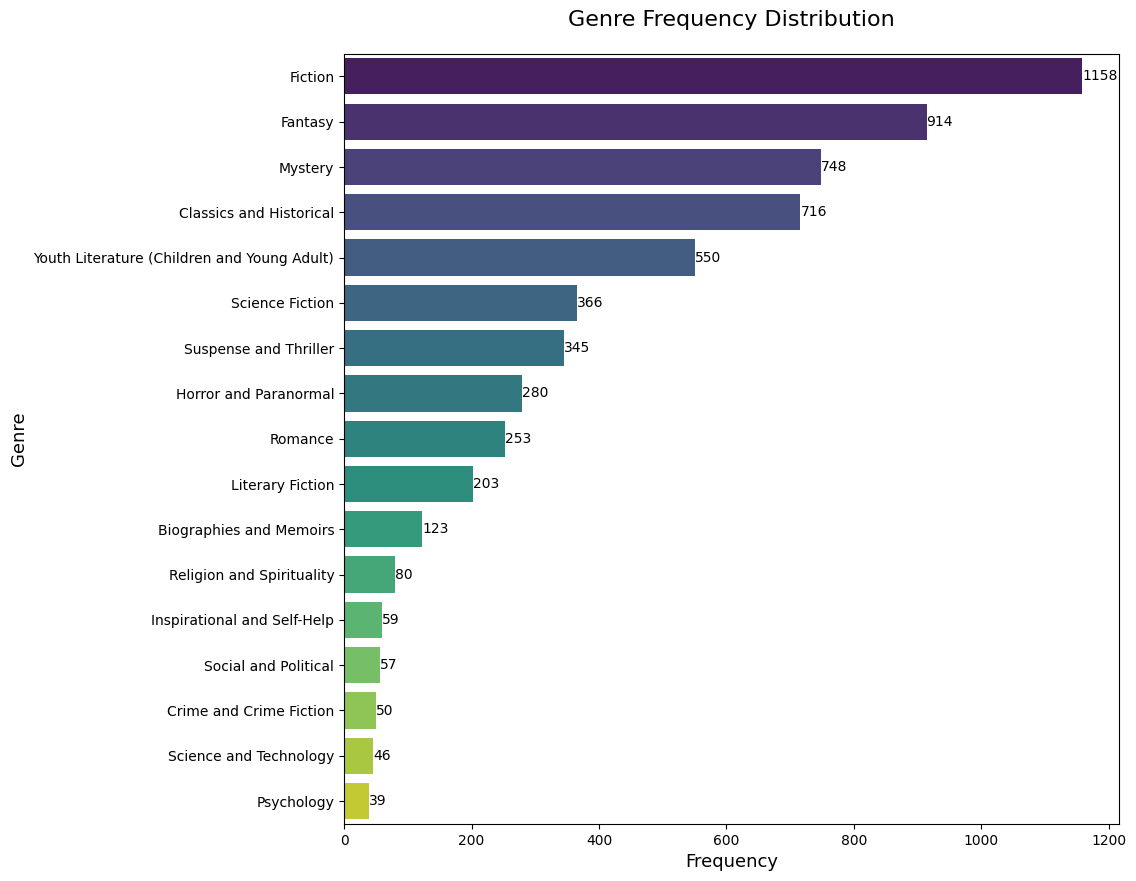

In [53]:
plt.figure(figsize = (10,10))
sns.barplot(x = genre_counts.values, y = genre_counts.index, palette = "viridis")
plt.xlabel("Frequency", fontsize = 13)
plt.ylabel("Genre",  fontsize = 13)
plt.title("Genre Frequency Distribution", pad = 20, fontsize = 16)

for index, value in enumerate(genre_counts.values):
    plt.text(value, index, str(value), va = 'center')
    
plt.show()

## **5. Merging Goodreads Dataset with 4 Minute Summary Dataset**

Since some of the genres have a very low count even after merging, we will use a dataset from kaggle to aid our original dataset.

In [54]:
df1 = pd.read_csv("C:/Users/HP/Downloads/FourMinuteBookSummaries.csv")

In [55]:
df1.head()

,Unnamed: 0,Summary,GroupedGenres
0,0,"is a self-assessment guide and how-to-live template for people who feel, relate, process, and notice more deeply than others, and who frequently suffer from overstimulation as a result.",Science and Technology
1,1,"is a collection of a clinical psychologist’s best practical advice to combat anxiety and depression and improve our mental health in small increments, collected from over a decade of 1-on-1 work with patients.",Science and Technology
2,2,"tells the story of Nora, a depressed woman in her 30s, who, on the day she decides to die, finds herself in a library full of lives she could have lived, where she discovers there’s a lot more to life, even her current one, than she had ever imagined.",Science and Technology
3,3,"presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance.",Science and Technology
4,4,is the story of a man questioning the system that keeps his futuristic but dystopian society afloat and the chaos that quickly ensues once he gives in to his natural curiosity and desire to be free.,Science and Technology


In [56]:
df1.drop('Unnamed: 0', inplace = True, axis = 1)

In [57]:
df1.shape

(1295, 2)

#### **Concatenating the datasets**

In [58]:
df = pd.concat([df, df1])

In [59]:
df.shape

(7282, 2)

In [60]:
df['GroupedGenres'].value_counts()

GroupedGenres
Fiction                                        1158
Fantasy                                         914
Mystery                                         748
Classics and Historical                         716
Psychology                                      621
Youth Literature (Children and Young Adult)     550
Inspirational and Self-Help                     369
Science Fiction                                 366
Suspense and Thriller                           345
Science and Technology                          341
Horror and Paranormal                           280
Romance                                         253
Literary Fiction                                203
Biographies and Memoirs                         202
Religion and Spirituality                       109
Social and Political                             57
Crime and Crime Fiction                          50
Name: count, dtype: int64

#### **Since some of the genres still have a very low count and can hinder our model performance so we will drop them.**

In [61]:
# We will remove the following genres since they have a very low count
genres_to_remove = ['Religion and Spirituality','Social and Political','Crime and Crime Fiction']


In [62]:
df = df[~df['GroupedGenres'].isin(genres_to_remove)]
df.reset_index(drop = True, inplace = True)

C:\Users\HP\AppData\Local\Temp\ipykernel_15244\3442204094.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = genre_counts.values, y = genre_counts.index, palette = "viridis")


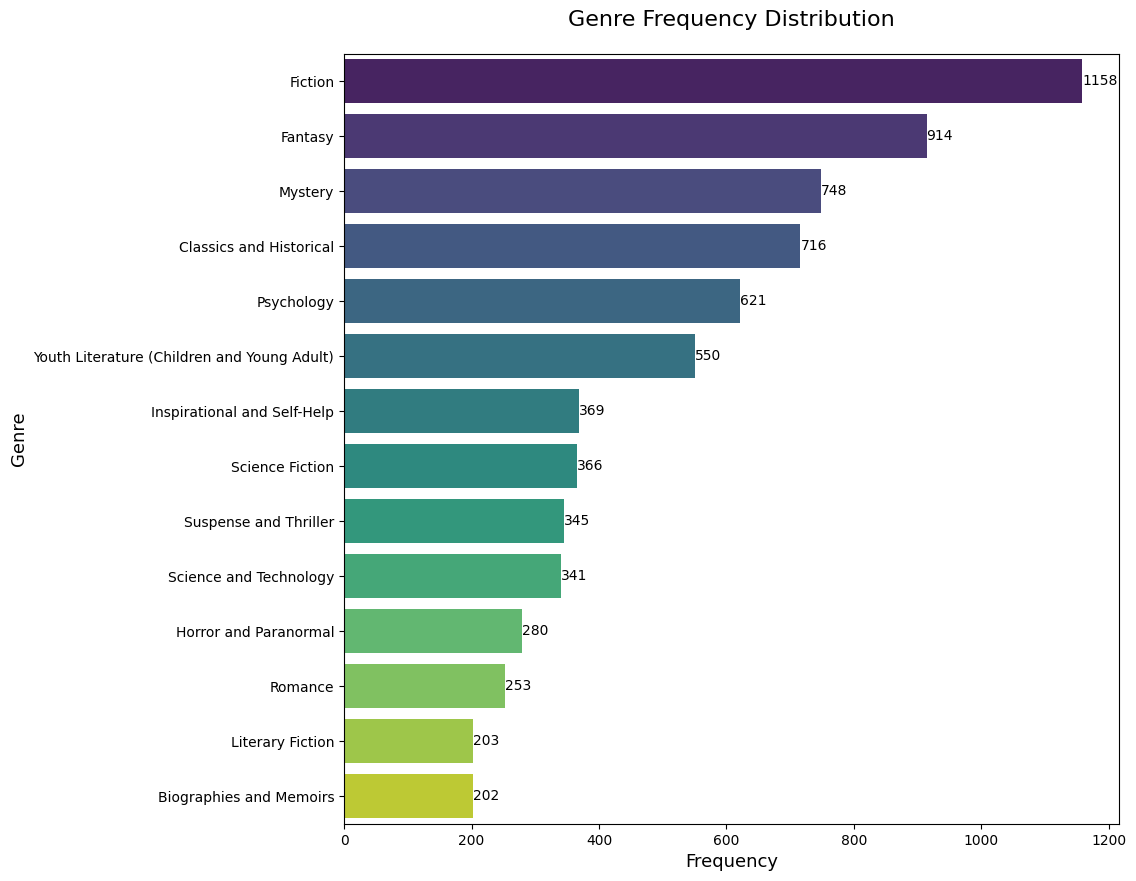

In [63]:
genre_counts = df["GroupedGenres"].value_counts()

plt.figure(figsize = (10,10))
sns.barplot(x = genre_counts.values, y = genre_counts.index, palette = "viridis")
plt.xlabel("Frequency", fontsize = 13)
plt.ylabel("Genre",  fontsize = 13)
plt.title("Genre Frequency Distribution", pad = 20, fontsize = 16)

for index, value in enumerate(genre_counts.values):
    plt.text(value, index, str(value), va = 'center')
    
plt.show()

## **6. Writing Function To Clean Text**

### **a. Clean Summary Text**

In [64]:
# nltk.download('stopwords')

In [65]:
#stop_words = set(stopwords.words('english'))

In [66]:
def clean_summary(summary):
    stopwords = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are',  'aren', "aren't", 'as', 'at', 
                     'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both','but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', 
                     "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 
                     'hadn', "hadn't",'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 
                     'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't",
                     'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
                     'other', 'our', 'ours', 'ourselves', 'out','over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', 
                     "shouldn't",'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they',
                     'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't",'we', 'were', 'weren', "weren't", 'what', 'when',
                     'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 
                     'your', 'yours', 'yourself', 'yourselves'}     
        
    summary = re.sub(
        r'(\bNew York Times Bestseller|Winner of the Pulitzer Prize|ANDNEW YORK TIMESBESTSELLERIn|ISBN|ASIN\b'
        r'|Librarian note|Alternate cover edition.*?|(This|There) is an alternate Cover Edition.*?|forASIN:\s*\S+|'
        r'\b\w*(ASIN|ISBN)\w*\b'
        r'ASIN:\s*\S+|ISBN[:\d]+)',
        '',
        summary,
        flags=re.IGNORECASE
    ).strip()

    
    summary = re.sub(r'\b[Ww]{2}\b', 'world war', summary)

    # Remove characters like M.D. or m.d.
    summary = re.sub(r'[A-Za-z]\.[A-Za-z]\.', '', summary)
    
    # Remove characters like M. or m.
    summary = re.sub(r'\b[A-Za-z]\.(?=\s|$)','',summary)

    # Remove characters like DR. or dr.
    summary = re.sub(r'\b[A-Za-z]{2}\.\s?', '', summary)
    
    # Remove html tags
    summary = BeautifulSoup(summary, 'html.parser').get_text()
    
    # Remove special characters and punctuation(i.e. ?, @, ',' etc) (\. leaves full stop,\w leaves word characters like _,a,z , \s leaves white space)
    summary = re.sub(r'[^\w\s\.]', ' ', summary)

    # Remove underscores
    summary = re.sub(r'\_+',' ', summary)

    # Remove numbers
    summary = re.sub(r'[0-9]','',summary)

    # Remove Roman numerals
    summary = re.sub(r'\b[IVXLCDM]+\b','',summary)

    # Convert to lower case
    summary = summary.lower()

    # Replace ellipses with white space
    summary = re.sub(r'\.\.\.*', ' ', summary)
    summary = re.sub(r'\.\s*\.\s*\.+', ' ', summary)
    summary = re.sub(r'\s*\.\s*\.\s*\.',' ', summary)

    # Remove stop words
    summary = ' '.join([word for word in summary.split() if word not in stopwords])

    summary = re.sub(
        r'award winning author|world bestselling authors|new york timesbestselling author|new york timesbestselleryou|new york times bestselling|goodreads|phenomenal worldwide bestseller|alternate cover|newer edition foundhere|national book award|pulitzer prize||national book award winner|pulitzer prize winner|new york timesandusa todaybestselling',
        '',
        summary,
        flags = re.IGNORECASE
    ).strip()

    # Remove extra spaces and clean text
    # \s checks for white space, + matches for preceding characters(i.e. one or more whitespace)
    summary = re.sub(r'\s+', ' ', summary).strip()

    # Remove white space before full stop
    summary = re.sub(r'\s+(?=\.)', '', summary)

    # Ensure there is a single white space after each full stop.
    summary = re.sub(r'\.(?=\S)', '. ', summary)
    
    return summary

### **b. Testing The Function**

In [67]:
clean_summary("""
In this unforgettable chronicle of perhaps the most famous moment in American military history, James Bradley has captured the glory, 
the triumph, the heartbreak, and the legacy of the six men who raised the flag at Iwo Jima. Here is the true story behind the immortal photograph 
that has come to symbolize the courage and indomitable will of America. In February 1945, American Marines plunged into the surf at Iwo Jima—and into 
history. Through a hail of machine-gun and mortar fire that left the beaches strewn with comrades, they battled to the island's highest peak. 
And after climbing through a landscape of hell itself, they raised a flag. Now the son of one of the flagraisers has written a powerful account 
of six very different young men who came together in a moment that will live forever. To his family, John Bradley never spoke of the photograph or 
the war. But after his death at age seventy, his family discovered closed boxes of letters and photos. In Flags of Our Fathers, James Bradley draws 
on those documents to retrace the lives of his father and the men of Easy Company. Following these men's paths to Iwo Jima, James Bradley has 
written a classic story of the heroic battle for the Pacific's most crucial island—an island riddled with Japanese tunnels and 22,000 fanatic 
defenders who would fight to the last man. But perhaps the most interesting part of the story is what happened after the victory. The men in the 
photo—three were killed during the battle—were proclaimed heroes and flown home, to become reluctant symbols. For two of them, the adulation was 
shattering. Only James Bradley's father truly survived, displaying no copy of the famous photograph in his home, telling his son only: The real heroes
of Iwo Jima were the guys who didn't come back. Few books ever have captured the complexity and furor of war and its aftermath as well as Flags of Our
Fathers. A penetrating, epic look at a generation at war, this is history told with keen insight, enormous honesty, and the passion of a son paying 
homage to his father. It is the story of the difference between truth and myth, the meaning of being a hero, and the essence of the human experience
of war. From the Hardcover edition.
""")


'unforgettable chronicle perhaps famous moment american military history james bradley captured glory triumph heartbreak legacy six men raised flag iwo jima. true story behind immortal photograph come symbolize courage indomitable america. february american marines plunged surf iwo jima history. hail machine gun mortar fire left beaches strewn comrades battled island highest peak. climbing landscape hell raised flag. son one flagraisers written powerful account six different young men came together moment live forever. family john bradley never spoke photograph war. death age seventy family discovered closed boxes letters photos. flags fathers james bradley draws documents retrace lives father men easy company. following men paths iwo jima james bradley written classic story heroic battle pacific crucial island island riddled japanese tunnels fanatic defenders would fight last man. perhaps interesting part story happened victory. men photo three killed battle proclaimed heroes flown ho

In [68]:
clean_summary("The Phenomenal #1 Worldwide Bestseller—With a New AfterwordHillary Rodham Clinton is known to hundreds of millions of people around the world. Yet few beyond her close friends and family have ever heard her account of her extraordinary journey. ")

'new afterwordhillary rodham clinton known hundreds millions people around world. yet beyond close friends family ever heard account extraordinary journey.'

In [69]:
clean_summary("""Alternate cover for ISBN 9780345350688Through a life of passion and struggle, Malcolm X became one of the most influential figures of the 20th Century. In this riveting account, he tells of his journey from a prison cell to Mecca, describing his transition from hoodlum to Muslim minister. Here, the man who called himself "the angriest Black man in America" relates how his conversion to true Islam helped him confront his rage and recognize the brotherhood of all mankind.An established classic of modern America, "The Autobiography of Malcolm X" was hailed by the New York Times as "Extraordinary. A brilliant, painful, important book." Still extraordinary, still important, this electrifying story has transformed Malcolm X's life into his legacy. The strength of his words, and the power of his ideas continue to resonate more than a generation after they first appeared""")

'life passion struggle malcolm became one influential figures th century. riveting account tells journey prison cell mecca describing transition hoodlum muslim minister. man called angriest black man america relates conversion true islam helped confront rage recognize brotherhood mankind. an established classic modern america autobiography malcolm hailed new york times extraordinary. brilliant painful important book. still extraordinary still important electrifying story transformed malcolm life legacy. strength words power ideas continue resonate generation first appeared'

In [70]:
clean_summary("a doctor ww  WW dr. doll")

'doctor world war world war doll'

## **7. Applying `clean_summary` To `Summary` Column**

In [71]:
df.loc[:,'Clean_summary'] = df['Summary'].apply(clean_summary)

C:\Users\HP\AppData\Local\Temp\ipykernel_15244\2464055683.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  summary = BeautifulSoup(summary, 'html.parser').get_text()


In [72]:
df.head(10)

,Summary,GroupedGenres,Clean_summary
0,"It is the story of four seekers who arrive at a notoriously unfriendly pile called Hill House: Dr. Montague, an occult scholar looking for solid evidence of a ""haunting""; Theodora, the lighthearted assistant; Eleanor, a friendless, fragile young woman well acquainted with poltergeists; and Luke, the future heir of Hill House. At first, their stay seems destined to be merely a spooky encounter with inexplicable phenomena. But Hill House is gathering its powers—and soon it will choose one of them to make its own.",Horror and Paranormal,story four seekers arrive notoriously unfriendly pile called hill house montague occult scholar looking solid evidence haunting theodora lighthearted assistant eleanor friendless fragile young woman well acquainted poltergeists luke future heir hill house. first stay seems destined merely spooky encounter inexplicable phenomena. hill house gathering powers soon choose one make own.
1,"Last year, Annabel was ""the girl who has everything"" — at least that's the part she played in the television commercial for Kopf's Department Store.This year, she's the girl who has nothing: no best friend because mean-but-exciting Sophie dropped her, no peace at home since her older sister became anorexic, and no one to sit with at lunch. Until she meets Owen Armstrong.Tall, dark, and music-obsessed, Owen is a reformed bad boy with a commitment to truth-telling. With Owen's help, maybe Annabel can face what happened the night she and Sophie stopped being friends.",Youth Literature (Children and Young Adult),last year annabel girl everything least part played television commercial kopf department store. this year girl nothing best friend mean exciting sophie dropped peace home since older sister became anorexic one sit lunch. meets owen armstrong. tall dark music obsessed owen reformed bad boy commitment truth telling. owen help maybe annabel face happened night sophie stopped friends.
2,"WINNER OF THE PULITZER PRIZE ANDNEW YORK TIMESBESTSELLERIn the first volume of his monumental trilogy about the liberation of Europe in WW II, Pulitzer Prize winner Rick Atkinson tells the riveting story of the war in North AfricaThe liberation of Europe and the destruction of the Third Reich is a story of courage and enduring triumph, of calamity and miscalculation. In this first volume of the Liberation Trilogy, Rick Atkinson shows why no modern reader can understand the ultimate victory of the Allied powers without a grasp of the great drama that unfolded in North Africa in 1942 and 1943. That first year of the Allied war was a pivotal point in American history, the moment when the United States began to act like a great power.Beginning with the daring amphibious invasion in November 1942, An Army at Dawn follows the American and British armies as they fight the French in Morocco and Algeria, and then take on the Germans and Italians in Tunisia. Battle by battle, an inexperienced and sometimes poorly led army gradually becomes a superb fighting force. Central to the tale are the extraordinary but fallible commanders who come to dominate the battlefield: Eisenhower, Patton, Bradley, Montgomery, and Rommel.Brilliantly researched, rich with new material and vivid insights, Atkinson's narrative provides the definitive history of the war in North Africa.",Classics and Historical,first volume monumental trilogy liberation europe world war winner rick atkinson tells riveting story war north africathe liberation europe destruction third reich story courage enduring triumph calamity miscalculation. first volume liberation trilogy rick atkinson shows modern reader understand ultimate victory allied powers without grasp great drama unfolded north africa. first year allied war pivotal point american history moment united states began act like great power. beginning daring amphibious invasion november army dawn follows american british armies fight french morocco algeria take germans italians tunisi

In [73]:
df.drop(['Summary'], inplace = True, axis = 1)

In [74]:
df.head()

,GroupedGenres,Clean_summary
0,Horror and Paranormal,story four seekers arrive notoriously unfriendly pile called hill house montague occult scholar looking solid evidence haunting theodora lighthearted assistant eleanor friendless fragile young woman well acquainted poltergeists luke future heir hill house. first stay seems destined merely spooky encounter inexplicable phenomena. hill house gathering powers soon choose one make own.
1,Youth Literature (Children and Young Adult),last year annabel girl everything least part played television commercial kopf department store. this year girl nothing best friend mean exciting sophie dropped peace home since older sister became anorexic one sit lunch. meets owen armstrong. tall dark music obsessed owen reformed bad boy commitment truth telling. owen help maybe annabel face happened night sophie stopped friends.
2,Classics and Historical,first volume monumental trilogy liberation europe world war winner rick atkinson tells riveting story war north africathe liberation europe destruction third reich story courage enduring triumph calamity miscalculation. first volume liberation trilogy rick atkinson shows modern reader understand ultimate victory allied powers without grasp great drama unfolded north africa. first year allied war pivotal point american history moment united states began act like great power. beginning daring amphibious invasion november army dawn follows american british armies fight french morocco algeria take germans italians tunisia. battle battle inexperienced sometimes poorly led army gradually becomes superb fighting force. central tale extraordinary fallible commanders come dominate battlefield eisenhower patton bradley montgomery rommel. brilliantly researched rich new material vivid insights atkinson narrative provides definitive history war north africa.
3,Classics and Historical,early hours january north vietnamese launched one hundred attacks across south vietnam would become known tet offensive. lynchpin tet capture hue vietnam intellectual cultural capital national liberation front troops descended hidden camps surged across city. within hours entire city hands save two small military outposts. american commanders refused believe size scope front presence ordering small companies marines thousands entrenched enemy troops. several futile deadly days lieutenant colonel ernie cheatham would finally come strategy retake city block block building building intense urban combat since world war unprecedented access war archives vietnam interviews participants sides bowden narrates stage crucial battle multiple viewpoints. played days ultimately costing lives battle hue far bloodiest entire war. ended american debate never winning leave. hue gripping moving account pivotal moment.
4,Literary Fiction,shakespeare king lear challenges us magnitude intensity sheer duration pain represents. figures harden hearts engage violence try alleviate suffering others. lear rages sanity cracks. keeps bringing us back king lear force language king lear almost equally powerful translated suggesting story large part draws us play. the play tells us families struggling greed cruelty one hand support consolation other. emotions extreme magnified gigantic proportions. also see old age portrayed vulnerability pride perhaps wisdom one reason devastating shakespeare tragedies also perhaps moving. the authoritative edition king lear folger shakespeare library trusted widely used shakespeare series students general readers includes freshly edited text based best early printed version play full explanatory notes conveniently placed pages facing text play scene scene plot summaries key play famous lines phrases introduction reading shakespeare language essay leading shakespeare scholar providing modern perspective play fresh images folger shakespeare library vast holdings rare books annotated guide readingessay susan snyderthe folger shakespeare library washington home world largest collec

## **8. Exporting Cleaned Dataset**

In [1]:
#df.to_csv("C:/Users/HP/Downloads/CombinedSummaries.csv")